# Learn the basics about notebooks and Apache Spark

This notebook introduces you to the basics of analytics notebooks and explains what Apache Spark is and how to use Spark in notebooks. The notebook shows you how to load data into the notebook, parse and explore the data, run queries on the data to extract information, plot your analysis results, and save your result in Object Storage.

This notebooks runs on Python 2 with Spark 2.x, and Object Storage (Swift API).

## Table of contents
- [What is Apache Spark](#apache_spark)
- [Get data](#data_set)
- [Load data](#load_data)
- [Access data](#access_data)
- [Add header](#add_header)
- [Parse data](#parse_data)
- [Explore data](#explore_data)
- [Use Spark SQL](#use_spark_sql)
- [Save results in Object Storage](#save)
- [Summary](#summary)

<a id="apache_spark"></a>
## What is Apache Spark

[Spark](http://spark.apache.org/) is a fast open-source engine for large-scale data processing. It is built for speed and ease of use. Through the advanced DAG execution engine that supports cyclic data flow and in-memory computing, programs can run up to 100 times faster than Hadoop MapReduce in memory, or 10 times faster on disc.

Spark consists of multiple components:

* Spark Core is the underlying computation engine with the fundamental programming abstraction called resilient distributed datasets (RDDs)
* Spark SQL provides a new data abstraction called DataFrames for structured data processing with SQL and domain-specific language
* MLlib is a scalable machine learning framework for delivering fast distributed algorithms for mining big data
* Streaming leverages Spark's fast scheduling capability to perform real-time analysis on streams of new data
* GraphX is the graph processing framework for the analysis of graph structured data

In this sample, you will focus on Spark Core and Spark SQL by using the Python API.

<a id="data_set"></a>
## Get data

In the sample, you will use Apache Spark to analyze weather data collected from weather stations in 2017. This data is provided by the NOAA National Climatic Data Center (NCDC).

To get at the raw data from the NOAA National Climatic Data Center (NCDC):

1. Visit the NCDC site at http://www.ncdc.noaa.gov/data-access/quick-links.
2. Click **Global Historical Climatology Network-Daily (GHCN-D)**.
3. Click **GHCN-Daily FTP Access**.
4. Click the `by_year` folder.
5. Scroll to the bottom and click **2017.cs.gz** to download the data set.
6. After the file was downloaded, extract it.
7. Click **ghcn-daily-by_year-format.rtf** to download additional infromation, e.g. header, for the data set.

The data in the base file has the following format:

<table border="1" style="width:90%">
  <tr>
    <th>STATION</th><th>DATE</th><th>METRIC</th><th>VALUE</th><th>C5</th><th>C6</th><th>C7</th><th>C8</th>
  </tr>
  <tr>
    <td>US1NCBC0113</td><td>20170101</td><td>PRCP</td><td>5</td><td></td><td></td><td>N</td><td></td>
  </tr>
  <tr>
    <td>CA1MB000296</td><td>20170101</td><td>PRCP</td><td>0</td><td></td><td></td><td>N</td><td></td>
  </tr>
  <tr>
    <td>...</td><td>...</td><td>...</td><td>...</td><td>...</td><td>...</td><td>...</td><td></td>
  </tr>
  <tr>
    <td>US1MTMH0019</td><td>20170101</td><td>SNOW</td><td>28</td><td></td><td></td><td>N</td><td></td>
  </tr>
  <tr>
    <td>...</td><td>...</td><td>...</td><td>...</td><td>...</td><td>...</td><td>...</td><td></td>
  </tr>
  <tr>
    <td>USW00024229</td><td>20170101</td><td>TMAX</td><td>44</td><td></td><td></td><td>W</td><td>2400</td>
  </tr>
</table>
<p>

Each row contains a weather station identifier, a date, a metric which is collected (like precipitation, daily maximum and minimum temperatures, temperature at the time of observation, snowfall, snow depth, and so on) and some additional values.

**Note**: The header is not included in the CSV file and is documented in **ghcn-daily-by_year-format.rtf**. It was added to the table above to provide clarity on what information each column contains.

<a id="load_data"></a>
## Load data
To load the CSV file to your notebook: 

1. Click the **Data** icon on the notebook action bar. 
2. Click on **browse** to add 2017.csv file.

The data file is now listed on the **Files** tab of the **Data** panel and is stored in Object Storage.

**Note**: Because the CSV file is relatively large, it might take a few minutes to load the data file. 

<a id="access_data"></a>
## Access data
Before you can access data in the data file in the Object Storage, you must setup the Spark configuration with your Object Storage credentials. 

To do this, click on the cell below and select the **Insert to code > Insert Credentials** function from the Files tab below the data file you want to work with.

<div class="alert alert-block alert-info">The credentials object that is created for you is given a generic name. Rename it to `YourCredentials` before you run the cell.</div>

In [1]:
# Click on this cell to select "Insert to code > Insert credentials" from right-hand panel


Now let's load the data into a `Spark RDD` we will call `weather` by using the `SparkContext`.

In [2]:
import ibmos2spark

bmos = ibmos2spark.bluemix(sc, YourCredentials, 'learnspark')

weather = sc.textFile(bmos.url(YourCredentials['container'], '2017.csv'))
weather.take(5)

[u'US1NCBC0113,20170101,PRCP,5,,,N,',
 u'CA1MB000296,20170101,PRCP,0,,,N,',
 u'US1MTMH0019,20170101,PRCP,43,,,N,',
 u'US1MTMH0019,20170101,SNOW,28,,,N,',
 u'US1MTMH0019,20170101,SNWD,178,,,N,']

You can now access the data by using the preconfigured `SparkContext` function in your notebook.

The RDD you created is a collection of strings corresponding to the individual lines in the raw data file. It is also important to remember that the RDD is defined but not instantiated. By applying an action like `count` to the RDD, you effectively instantiate the RDD.

In [3]:
print "Total records in the data set:", weather.count()

Total records in the data set: 32521454


Apply another action to the same RDD that reads the first row of the data.

In [4]:
print "The first row in the data set:", weather.first()

The first row in the data set: US1NCBC0113,20170101,PRCP,5,,,N,


<a id="add_header"></a>
## Add header

Since the header is not included in the CSV file, it has to be added programmatically.  

In [5]:
header = sc.parallelize(['STATION,DATE,METRIC,VALUE,C5,C6,C7,C8'])
union = header.union(weather)
weather = union
weather.take(2)

['STATION,DATE,METRIC,VALUE,C5,C6,C7,C8', u'US1NCBC0113,20170101,PRCP,5,,,N,']

<a id="parse_data"></a>
## Parse data

To really begin working with the data, you need to parse it into columns. You can do this by mapping each line in the RDD to a function that splits the line by commas.

The lambda notation in Python is used to create anonymous functions, in other words, functions which are not bound to a name. This concept is used in the previous code cell to pass a function as a parameter to the `map` function. The anonymous function receives each line from the `weather` RDD  and splits it at comma boundaries. As a result, the new `weatherParse` RDD is defined as a list of lists. Each list in `weatherParse` corresponds to a line in `weather`, and the strings in each list are the individual elements of the row.

In [6]:
weatherParse = weather.map(lambda line : line.split(","))

Run the next cell for a quick look at the first list:

In [7]:
weatherParse.first()

['STATION', 'DATE', 'METRIC', 'VALUE', 'C5', 'C6', 'C7', 'C8']

Now take a look at the individual elements of this first list where the first entry starts at offset zero.

In [8]:
weatherParse.first()[0]

'STATION'

You can also pull elements by index.

In [9]:
weatherParse.first()[2]

'METRIC'

<a id="explore_data"></a>
## Explore data
To better consume the precipitation data, it has to be converted or mapped from one raw form into another format.


### Calculate the average precipitation by weather station
To calculate the average precipitation that was recorded at each weather station in the data set, reduce the data set by selecting only those rows with precipitation data values, in other words, those rows where the METRIC column equals `PRCP`.

In [10]:
weatherPrecp = weatherParse.filter(lambda x: x[2] == "PRCP")

The `weatherPrecp` RDD that you created contains a list of pairs (v1, v2), where v1 is a weather station identifier and v2 is one precipitation data point (one day) for that station. Table 1. depicts this structure.

#### Table 1.

<table border=1 style="width:80%" align="left">
  <tr>
    <th>Key</th><th>Value</th>
  </tr>
  <tr>
    <td>Station 1</td><td>Value 1</td>
  </tr>
  <tr>
    <td>Station 2</td><td>Value 2</td>
  </tr>
    <tr>
    <td>Station 1</td><td>Value 3</td>
  </tr>
    <tr>
    <td>Station 2</td><td>Value 4</td>
  </tr>
    <tr>
    <td>Station 3</td><td>Value 5</td>
  </tr>
  <tr>
    <td>...</td><td>...</td>
  </tr>
</table>
<p>

Next, transform (map) this data set into a new one where each row (data pair) is augmented with the value `1`. Table 2. shows this new structure.

#### Table 2.

<table border="1" style="width:80%" align="left">
  <tr>
    <th>Key</th><th>Value</th>
  </tr>
  <tr>
    <td>Station 1</td><td>(Value 1,1)</td>
  </tr>
  <tr>
    <td>Station 2</td><td>(Value 2,1)</td>
  </tr>
    <tr>
    <td>Station 1</td><td>(Value 3,1)</td>
  </tr>
    <tr>
    <td>Station 2</td><td>(Value 4,1)</td>
  </tr>
    <tr>
    <td>Station 3</td><td>(Value 5,1)</td>
  </tr>
  <tr>
    <td>...</td><td>...</td>
  </tr>
</table>
<p>

The reason for this mapping is to reduce the table into the form represented by Table 3.

#### Table 3.

<table border="1" style="width:80%" align="left">
  <tr>
    <th>Key</th><th>Value</th>
  </tr>
  <tr>
    <td>Station 1</td><td>(Value 1 + Value 3,2)</td>
  </tr>
  <tr>
    <td>Station 2</td><td>(Value 2 + Value 4,2)</td>
  </tr>
    <tr>
    <td>Station 3</td><td>(Value 5,1)</td>
  </tr>
  <tr>
    <td>...</td><td>...</td>
  </tr>
</table>
<p>

Using this table, you can compute the average precipitation for each station by dividing the summation of the values by the corresponding count.

Run the next code cell to create `weatherPrecpCountByKey`. The outcome is the equivalent to what you see in Table 2.

In [11]:
# x[0] is the station
# x[3] is the precipitation value
weatherPrecpCountByKey = weatherPrecp.map(lambda x : (x[0], (int(x[3]), 1)))

The same Python lambda function notation is used to pass a function into the mapping function which transforms `weatherPrecp` into the new RDD. 

To confirm that the mapping produced the expected results, run the next cell:

In [12]:
weatherPrecpCountByKey.first()

(u'US1NCBC0113', (5, 1))

### Calculate the total precipitation by weather station

To calculate the total precipitation by weather station, sum (reduce) the precipitation amounts and total readings for every station. Use the `reduceByKey` function for this purpose.

In [13]:
weatherPrecpAddByKey = weatherPrecpCountByKey.reduceByKey(lambda v1,v2 : (v1[0]+v2[0], v1[1]+v2[1]))

Using the `first` function, you can inspect the precipitation values and read the totals for the first station ID. Note that this operation might take some time to complete as the whole chain of RDDs that you created are reinstantiated.

In [14]:
weatherPrecpAddByKey.first()

(u'US1COLR0036', (4315, 363))

### Compute the average values per station

Now that you have transformed the data into the format you need it in, you can finally compute the average precipitation values per weather station. You create the `weatherAverages` RDD by mapping the `weatherPrecpAddByKey` RDD through a function that divides the precipitation total by the total number of readings.

In [15]:
weatherAverages = weatherPrecpAddByKey.map(lambda k: (k[0], k[1][0] / float(k[1][1] ) ) )

In [16]:
weatherAverages.first()

(u'US1COLR0036', 11.887052341597796)

Now print the first ten stations and their average precipitation values. The station ID is the sort order in the `top` function because it appears first in the tuple (station ID, average precipitation) in the RDD.

In [17]:
for pair in weatherAverages.top(10):
    print "Station %s had average precipitations of %f" % (pair[0],pair[1])

Station ZI000067983 had average precipitations of 82.493671
Station ZI000067975 had average precipitations of 49.165049
Station ZI000067775 had average precipitations of 67.142857
Station ZA000067743 had average precipitations of 255.428571
Station ZA000067475 had average precipitations of 119.000000
Station WZ004455110 had average precipitations of 55.611111
Station WQW00041606 had average precipitations of 61.218750
Station WIM00060096 had average precipitations of 10.555556
Station WFM00091754 had average precipitations of 108.035714
Station WF000917530 had average precipitations of 100.651099


If you want to output the ten weather stations with the highest average precipitation, you need to reverse the order of the tuple to (average precipitation, station ID). You can do this with a `map` function that switches the pair order.

In [18]:
precTop10=[]
stationsTop10=[]
for pair in weatherAverages.map(lambda (x,y) : (y,x)).top(10):
    precTop10.append(pair[0])
    stationsTop10.append(pair[1])
    print "Station %s had average precipitations of %f" % (pair[1],pair[0])

Station US1TXMNG018 had average precipitations of 2809.000000
Station US1TXFB0025 had average precipitations of 2161.500000
Station US1MOCY0024 had average precipitations of 2009.000000
Station US1ILDP0144 had average precipitations of 1808.000000
Station US1MOJH0005 had average precipitations of 1803.500000
Station US1TXJJ0003 had average precipitations of 1489.750000
Station US1NCCL0021 had average precipitations of 1448.000000
Station US1TNMT0049 had average precipitations of 1361.000000
Station US1TXWK0011 had average precipitations of 1346.200000
Station US1FLBW0046 had average precipitations of 1333.666667


Plot your results.

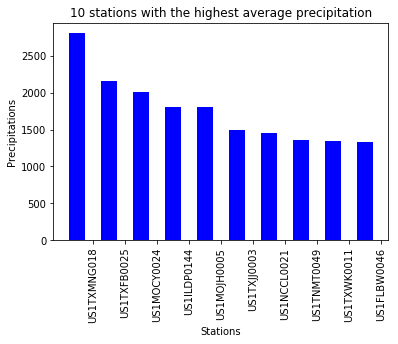

In [19]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt

N = 10
index = np.arange(N)  
bar_width = 0.5

plt.bar(index, precTop10, bar_width,
                 color='b')
plt.xlabel('Stations')
plt.ylabel('Precipitations')
plt.title('10 stations with the highest average precipitation')
plt.xticks(index + bar_width, stationsTop10, rotation=90)
plt.show()

<a id="use_spark_sql"></a>
## Use Spark SQL

`Spark SQL` lets you query structured data, for example, data in a relational table and can be a very powerful tool for performing complex aggregations.

To create a relational table that you can query using `Spark SQL` and fill it with snowfall data, you'll use the `Row` class from the `pyspark.sql` package. You will use every line in the `weatherSnow` RDD to create a row object. Each of the row's attributes will be used to access the value of each column.

To filter the weather data to show only those weather stations that contain the keyword SNOW, you need to reduce the data set to lines with SNOW in the third column. To do this, run the following commands:

In [20]:
weatherSnow = weatherParse.filter(lambda x: x[2]=="SNOW")
weatherSnow.count()

4185631

The next commands convert each line of the `weatherSnow` RDD into a row object, infer and apply a schema to an RDD of row objects, and register the table name `snow2017`.

In [21]:
from datetime import datetime
from pyspark.sql import Row
spark = SparkSession.builder.getOrCreate()

# Convert each line of snowWeather RDD into a Row object
snowRows= weatherSnow.map(lambda p: Row(station=p[0], month=datetime.strptime(p[1], '%Y%m%d').month, date=datetime.strptime(p[1], '%Y%m%d').day,metric=p[2], value=int(p[3])))
# Apply Row schema
snowSchema = spark.createDataFrame(snowRows)
# Register 'snow2017' table with 5 columns: station, month, date, metric, and value
snowSchema.registerTempTable("snow2017")

### Compare the number of snow days between two stations

In this section, you'll calculate the number of snow days for each month of the year at the `US10chey021` 
and `USW00094985` weather stations. With that information, you'll plot a bar chart to compare the number of snow days for each month at the two stations.

First, find out on how many days of every month it snowed at the `US10chey021` weather station:

In [22]:
snow_US10chey021 = spark.sql("SELECT month, COUNT(*) AS snowdays FROM snow2017 WHERE station='US10chey021' GROUP BY month ORDER BY month").collect()

In [23]:
US10chey021_snowdays_y=[0] * 12
for row in snow_US10chey021:
    US10chey021_snowdays_y[row.month - 1]=row.snowdays
    
print US10chey021_snowdays_y

[28, 27, 21, 19, 10, 0, 0, 0, 0, 2, 1, 1]


Next, find out how many days of every month it snowed at the `USW00094985` weather station and plot the results:

In [24]:
snow_USW00094985 = spark.sql("SELECT  month, COUNT(*) AS snowdays FROM snow2017 WHERE station='USW00094985' GROUP BY month ORDER BY month").collect()

In [25]:
USW00094985_snowdays_y=[0] * 12
for row in snow_USW00094985:
    USW00094985_snowdays_y[row.month -1]=row.snowdays
    
print USW00094985_snowdays_y

[25, 24, 22, 29, 31, 30, 31, 31, 30, 31, 30, 26]


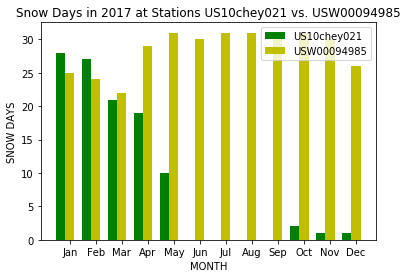

In [26]:
%matplotlib inline
import matplotlib
import numpy as np
import matplotlib.pyplot as plt

N=12
ind=np.arange(N)
width = 0.35
pUS10chey021 = plt.bar(ind, US10chey021_snowdays_y, width, color='g', label='US10chey021')
pUSW00094985 = plt.bar(ind+width, USW00094985_snowdays_y, width, color='y', label='USW00094985')

plt.ylabel('SNOW DAYS')
plt.xlabel('MONTH')
plt.title('Snow Days in 2017 at Stations US10chey021 vs. USW00094985')
plt.xticks(ind+width, ('Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'))
plt.legend()

plt.show()

### Determine the number of snow days at each US weather station
To determine how many snow days there were at each of the US weather stations in 2017, run the following command to query the `snow2017` table, using the `COUNT(*)` function to get the total snow days. The table is sorted by station name and limited to only 100 stations.

In [27]:
snowStations = spark.sql("SELECT  station, COUNT(*) AS snowdays FROM snow2017 WHERE station LIKE 'US%' GROUP BY station ORDER BY station LIMIT 100")

Now print the first 5 rows of the `snowStations` table, including the station name and number of snow days at that station:

In [28]:
snowStations.head(5)

[Row(station=u'US10adam001', snowdays=1),
 Row(station=u'US10adam002', snowdays=26),
 Row(station=u'US10adam004', snowdays=101),
 Row(station=u'US10adam008', snowdays=1),
 Row(station=u'US10adam010', snowdays=1)]

### Save the query results into a new table

In this step, you will save the query result of the above `SELECT` query in a new table called `snowdays_2017`. The new table has two columns: STATION (name of station) and SNOWDAYS (number of snow days at the station). 

In [29]:
snowStations.registerTempTable('snowdays_2017')

Output the five stations with the highest number of snow days in 2017:

In [30]:
snowStations_new = spark.sql("SELECT station, snowdays FROM snowdays_2017 ORDER BY snowdays DESC LIMIT 5").collect()
for row in snowStations_new:
    print row

Row(station=u'US10adam056', snowdays=323)
Row(station=u'US10dawe026', snowdays=176)
Row(station=u'US10cust015', snowdays=114)
Row(station=u'US10chey019', snowdays=112)
Row(station=u'US10daws001', snowdays=111)


### Identify the stations with the same number of snow days in 2017

In this section, you'll identify the stations that had the same number of snow days in 2017. First, you need to query the table `snowdays_2017` again. 

Then, by using the `map` function, you'll transform each row into a key-value pair where the key is the number of snow days and the value is the station name.

Next, you'll apply the `reduceByKey` function to each pair, and the value of those pairs that have the same key are concatenated. As a result, the RDD contains the number of snow days, and the list of all stations that have the same number of snow days.

The `for` loop prints the number of snow days, and the list of stations that have that number of snow days in 2017.

In [31]:
snowdays_100 = spark.sql("SELECT station, snowdays FROM snowdays_2017")
snowday_stations=snowdays_100.rdd.map(lambda x:  (x.snowdays,x.station)).reduceByKey(lambda x, y: x + ',' + y)
for snowday in snowday_stations.collect():
    print 'Snow days:' + str(snowday[0]) + ' Stations:' + str(snowday[1])

Snow days:1 Stations:US10adam001,US10adam008,US10adam010,US10blai004,US10buff019,US10burt002,US10cher008,US10cher018,US10cher024,US10cher026,US10chey005,US10chey007,US10chey010,US10chey049,US10chey053,US10chey060,US10clay009,US10colf001,US10cust003,US10cust040,US10cust041,US10dawe017
Snow days:2 Stations:US10butl020,US10chas034,US10chey028,US10cust042
Snow days:3 Stations:US10adam035,US10buff007
Snow days:4 Stations:US10bann009,US10butl005,US10ceda009,US10cumi008,US10cust035
Snow days:5 Stations:US10chas012,US10chey033,US10cumi003
Snow days:6 Stations:US10chas016
Snow days:7 Stations:US10clay041,US10cust005
Snow days:8 Stations:US10boon010,US10clay008,US10colf002
Snow days:9 Stations:US10adam036,US10cher016,US10cust032,US10dako003
Snow days:10 Stations:US10buff004,US10chas011,US10clay029
Snow days:11 Stations:US10butl011
Snow days:12 Stations:US10buff039,US10cass005
Snow days:14 Stations:US10butl008,US10ceda006,US10clay004
Snow days:15 Stations:US10cust045
Snow days:19 Stations:US10box

<a id="save"></a>
## Save results in Object Storage

In this section, you'll save the `snowStations` DataFrame, which is the query result of the `snow2017` table for 100 US weather stations in Object Storage. Each row contains the name of the weather station and the number of snow days at that station.

The data will be saved in [Apache Parquet](https://parquet.apache.org/documentation/latest/) file format, which saves data as columns.

Each project you create has a container in your object storage. The name of the container is the same as the project name, minus any blank spaces. You can get the name of the container a couple of different ways: (1) from the **Settings** page of the project, and (2) using `YourCredentials['container']` variable that is generated from the **Insert Credentials** function.

In [32]:
# Save as parquet file 

# If you are running this cell multiple times, you will need to overwrite the data in the parquet file:
#     snowStations.write.mode('overwrite').parquet(bmos.url('CONTAINER', 'snowStations.parquet'))

snowStations.write.parquet(bmos.url(YourCredentials['container'], 'snowStations.parquet'))

After the DataFrame has been saved to Object Storage, you will see a new data source called `snowStations.parquet` in the `Data` pane. 

Change the string `CONTAINER` in the following code cell as well and run the cell to read the parquet file and register it as a table again. Once the parquet file is read, you can use the domain-specific language to access the data. When you register the resulting DataFrame as TempTable, you can run SQL queries on the data as well.

In [33]:
parquetFile = spark.read.parquet(bmos.url(YourCredentials['container'], 'snowStations.parquet'))
parquetFile.registerTempTable("snow_from_parquet")

<a id="summary"></a>
## Summary

In this sample, you learned how to use Apache Spark, how to use PySpark, the Python API for Spark and the matplotlib plotting library. You also learned how to load data from Object Storage as an RDD, how to define Spark data schemas, and how to save intermediate results in parquet format.

<a id="resources"></a>
### Resources
- [Apache Spark 2.1.0 Programming Guide](https://spark.apache.org/docs/2.1.0/programming-guide.html)
- [Apache Spark 2.1.0 SQL and DataFrames](https://spark.apache.org/docs/2.1.0/sql-programming-guide.html)
- [PySpark 2.1.0 - Python API for Spark](https://spark.apache.org/docs/2.1.0/api/python)

### Author
Sven Hafeneger is a member of the Data Science Experience development team at IBM in Germany. He holds a M.Sc. in Bioinformatics and is passionate about data analysis, machine learning and the Python ecosystem for data science. 

<hr>
Copyright © IBM Corp. 2016, 2018. This notebook and its source code are released under the terms of the MIT License.